In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pickle
import time
import os


#import AEs
from autoencoder_classes import(
    Autoencoder1, Autoencoder2, Autoencoder3, Autoencoder4, Autoencoder5, Autoencoder6, Autoencoder7, Autoencoder8, Autoencoder9, 
    Autoencoder10, Autoencoder11, Autoencoder12, Autoencoder13, Autoencoder14, Autoencoder15
)


AUTOENCODER_CLASSES = {
    "Autoencoder1": Autoencoder1,
    "Autoencoder2": Autoencoder2,
    "Autoencoder3": Autoencoder3,
    "Autoencoder4": Autoencoder4,
    "Autoencoder5": Autoencoder5,
    "Autoencoder6": Autoencoder6,
    "Autoencoder7": Autoencoder7,
    "Autoencoder8": Autoencoder8,
    "Autoencoder9": Autoencoder9,
    "Autoencoder10": Autoencoder10,
    "Autoencoder11": Autoencoder11,
    "Autoencoder12": Autoencoder12,
    "Autoencoder13": Autoencoder13,
    "Autoencoder14": Autoencoder14,
    "Autoencoder15": Autoencoder15
}


#import MT
import sys
sys.path.insert(0, '/data/shiyu/projects/MT/MT_ICML_OOP')
from MT_networks_wrapper import MTNetworksWrapper




def set_seed(seed: int):
    # random.seed(seed) # Python built‑in RNG
    np.random.seed(seed) # NumPy RNG
    torch.manual_seed(seed) # Torch CPU RNG

    # Torch CUDA RNG (all GPUs)
    torch.cuda.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed)
    
    # For deterministic behavior (may slow down training):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    
    os.environ['PYTHONHASHSEED'] = str(seed) #env‑level reproducibility

set_seed(42)


mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]
})

In [2]:
def count_multiplications_per_sample_AE(model):
    total_mults = 0
    for m in model.modules():
        if isinstance(m, nn.Linear):
            mults = m.in_features * m.out_features
            total_mults += mults
    return total_mults

# load data

In [3]:
sigma = 0.01
d = 2 

"""Load training and test data."""
print("Loading training data...")
train_file = os.path.join('/data/shiyu/projects/MT/MT_ICML_OOP/data/GW_data', 'datawaves_100000_spinsFalse_nonuniform.npy')
train_waves = np.load(train_file)

print("Loading test data...")
test_file = os.path.join('/data/shiyu/projects/MT/MT_ICML_OOP/data/GW_data', 'datawaves_20000_spinsFalse_nonuniform.npy')
test_waves = np.load(test_file)



X_natural_train = train_waves
X_natural_test = test_waves


N_train = X_natural_train.shape[0]
N_test = X_natural_test.shape[0]
D = X_natural_train.shape[1]


X_train = X_natural_train + sigma * np.random.randn(*X_natural_train.shape)
X_test = X_natural_test + sigma * np.random.randn(*X_natural_test.shape)


X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()



print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Ambient dimension (D): {D}")
print(f"Intrinsic dimension (d): {d}")
print(f"Noise level (sigma): {sigma}")

Loading training data...
Loading test data...
Training data shape: (100000, 2048)
Test data shape: (20000, 2048)
Ambient dimension (D): 2048
Intrinsic dimension (d): 2
Noise level (sigma): 0.01


# train and analyze AEs

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
save_path = '/data/shiyu/projects/MT/MT_ICML_OOP/GW/trained_models_info/AEs_GW.pkl'

AEs_training_loss_per_sample_epochs = []
AEs_test_MSE_list = []
AEs_mults_per_sample_list = []

all_states = {}

for name, model_class in AUTOENCODER_CLASSES.items():
    print(f'\nTraining {name}')
    model = model_class()
    model = model.to(device)
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    num_epochs  = 1000
    batch_size = 4000 

    #be consistent with MT.  if use all samples, num_batches = N_train // batch_size  + ((N_train % batch_size) != 0), num_samples_used = N_train, end_index = min(start_index + batch_size, N_train) 
    num_batches = N_train // batch_size + ((N_train % batch_size) != 0)
    


    training_loss_per_sample_list = []

    start_time = time.time()
    for epoch in range(num_epochs):
        loss_curr_epoch = 0
        for i in range(num_batches): 
            optimizer.zero_grad()

            start_index = i * batch_size
            end_index = min(start_index + batch_size, N_train)
            batch_input = X_train_tensor[start_index : end_index].to(device)
            batch_output = model(batch_input)
            
            loss =  criterion(batch_output, batch_input) 
            loss.backward()
            optimizer.step()

            num_samples_curr_batch = end_index - start_index
            loss_curr_epoch += loss.item() * num_samples_curr_batch # batch_size -> batch_end - start_index

            
        training_loss_per_sample_curr_epoch = loss_curr_epoch / N_train
        training_loss_per_sample_list.append(training_loss_per_sample_curr_epoch)

        print(f"epoch {epoch},{end_index} samples processed..., training loss per sample for the current epoch is {training_loss_per_sample_curr_epoch}")

    AEs_training_loss_per_sample_epochs.append(training_loss_per_sample_list) #store training losses for all AEs
        
    end_time = time.time()
    print(f"{name} training DONE... TOTAL TIME = {end_time - start_time}")
    

    all_states[name] =  model.state_dict()

    # evaluation on test data
    print(f'start evaluation on test data for {name}')
    with torch.no_grad():
        X_test_denoised = model(X_test_tensor.to(device))

    test_MSE = np.sum((X_test_denoised.detach().cpu().numpy() - X_natural_test)**2) / N_test
    print(f'MSE is {test_MSE}')
    AEs_test_MSE_list.append(test_MSE)


    mults_per_sample = count_multiplications_per_sample_AE(model)
    print(f'mutls per sample is {mults_per_sample}')
    AEs_mults_per_sample_list.append(mults_per_sample)
    print('----------------------------------------------------------------------------------------------')


if save_path:
    AEs_info = {
    'all_states': all_states,
    'AEs_training_loss_per_sample_epochs': AEs_training_loss_per_sample_epochs,
    'AEs_test_MSE_list': AEs_test_MSE_list,
    'AEs_mults_per_sample_list': AEs_mults_per_sample_list,
    }
    with open(save_path, 'wb') as f:
        pickle.dump(AEs_info, f)


Training Autoencoder1
epoch 0,100000 samples processed..., training loss per sample for the current epoch is 0.1597599655389786
epoch 1,100000 samples processed..., training loss per sample for the current epoch is 0.14144807457923889
epoch 2,100000 samples processed..., training loss per sample for the current epoch is 0.12246029168367385
epoch 3,100000 samples processed..., training loss per sample for the current epoch is 0.10338999897241592
epoch 4,100000 samples processed..., training loss per sample for the current epoch is 0.08533403754234314
epoch 5,100000 samples processed..., training loss per sample for the current epoch is 0.06911351770162583
epoch 6,100000 samples processed..., training loss per sample for the current epoch is 0.05511708825826645
epoch 7,100000 samples processed..., training loss per sample for the current epoch is 0.043418491780757906
epoch 8,100000 samples processed..., training loss per sample for the current epoch is 0.03388651967048645
epoch 9,100000

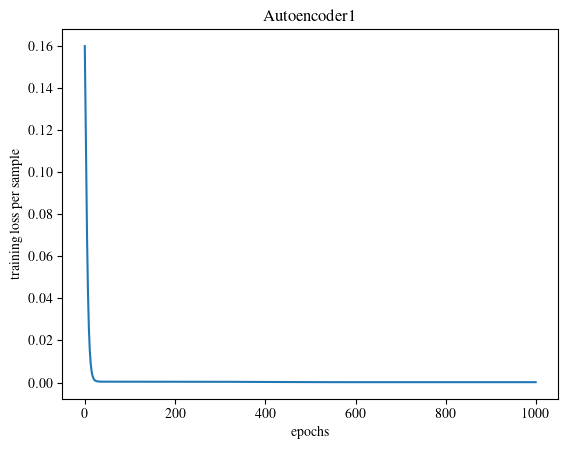

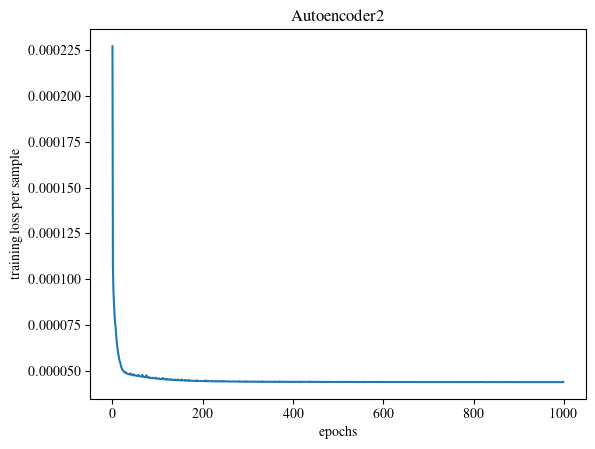

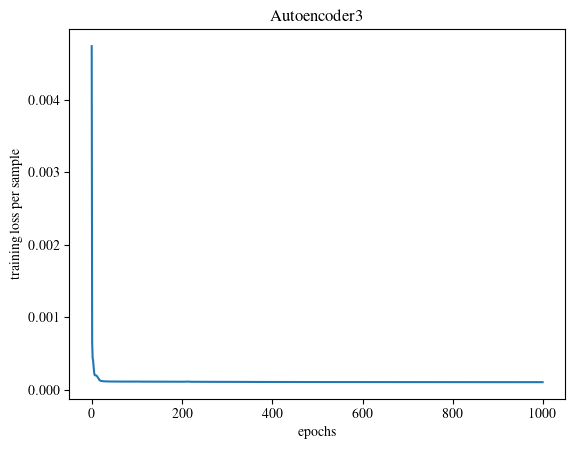

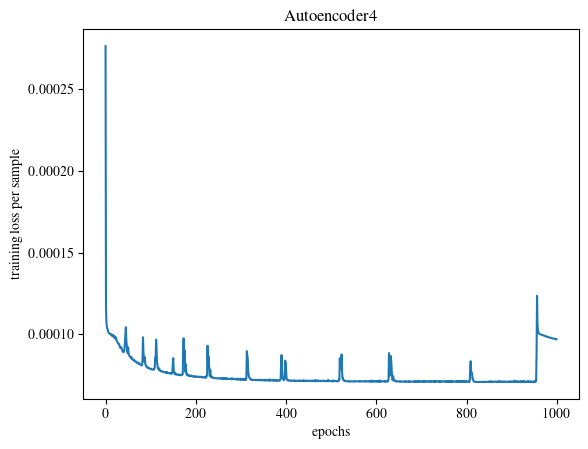

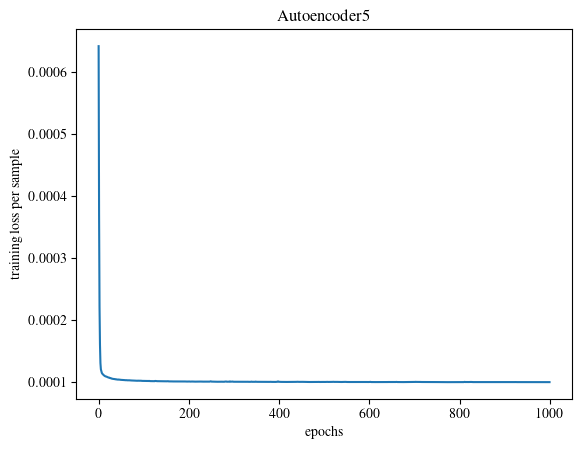

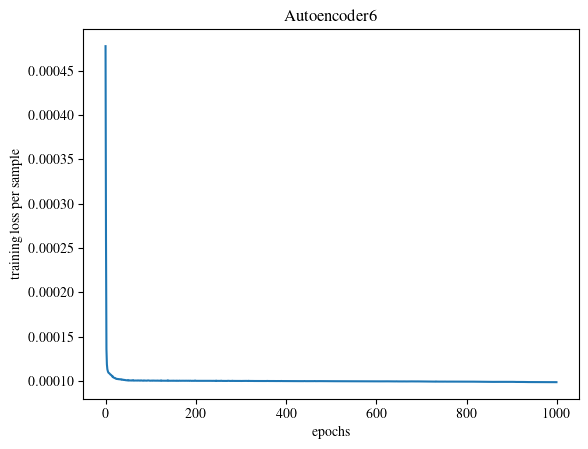

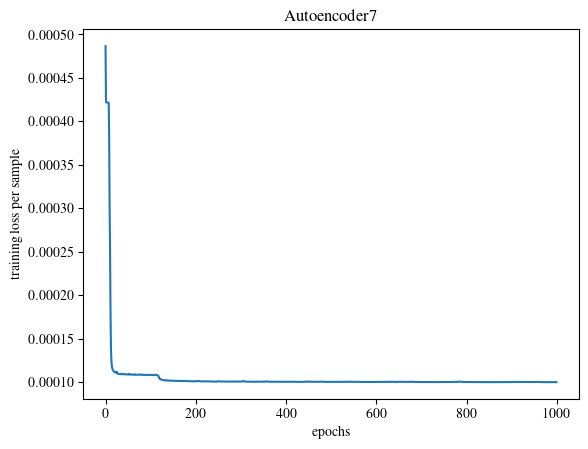

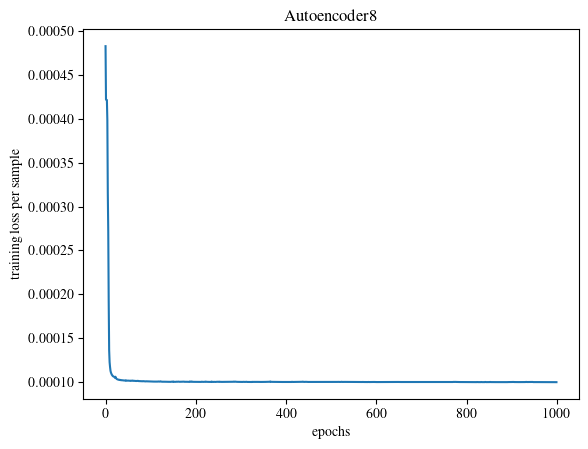

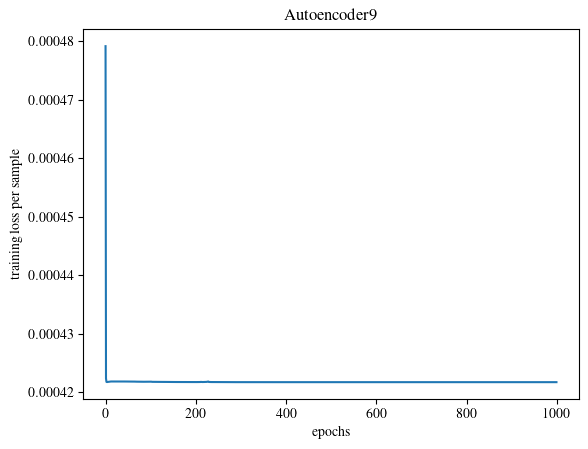

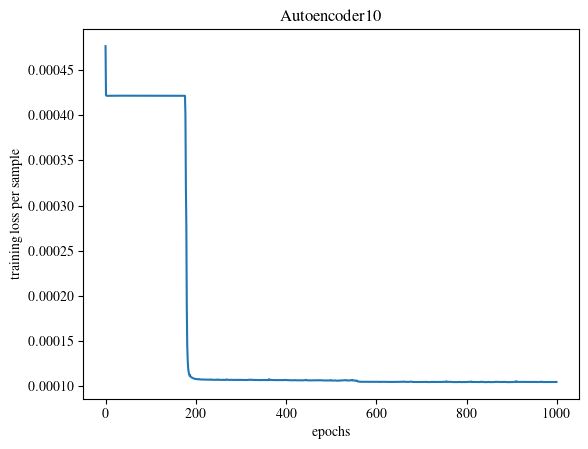

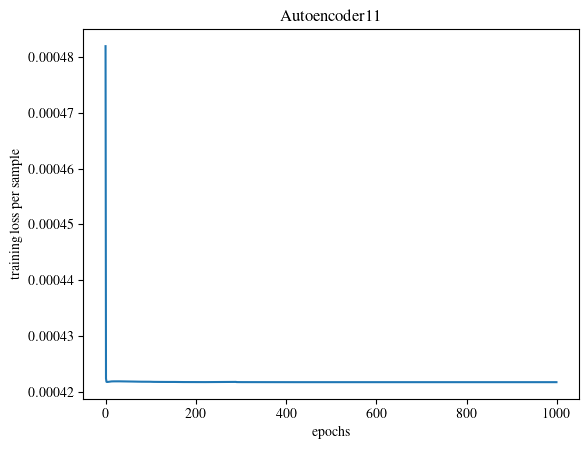

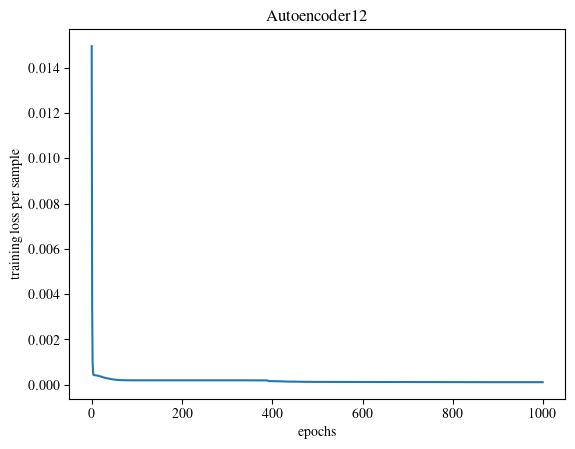

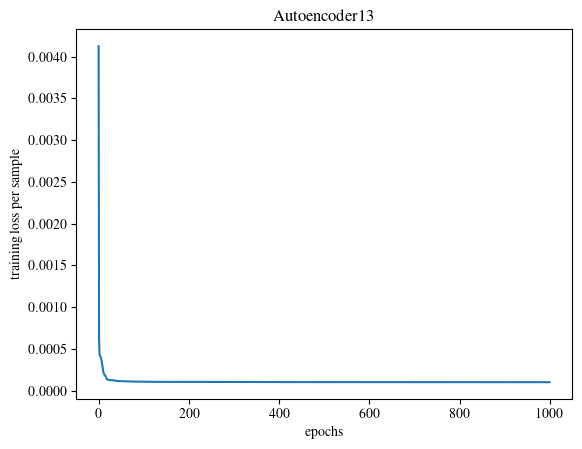

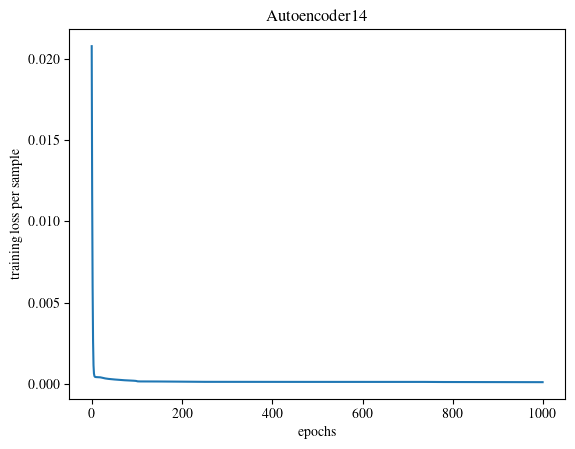

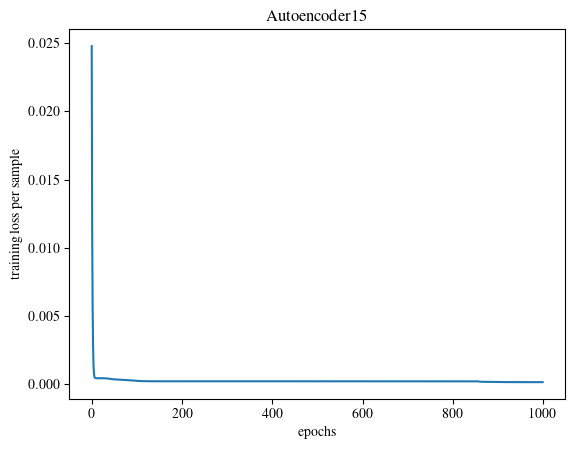

In [6]:
# plot AEs training loss curve
for i, (key, value) in enumerate(AUTOENCODER_CLASSES.items()):
    plt.figure()
    plt.plot(AEs_training_loss_per_sample_epochs[i])
    plt.xlabel('epochs')
    plt.ylabel('training loss per sample')
    plt.title(f'{key}')

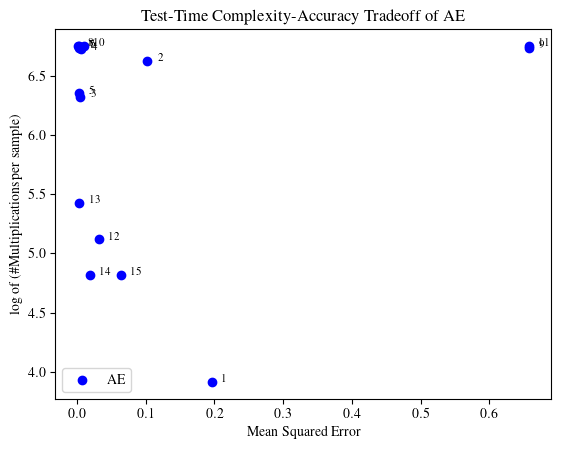

In [7]:
#plot trade-off curve for AEs

for i in range(len(AEs_test_MSE_list)): 
    plt.scatter(AEs_test_MSE_list[i], np.log10(AEs_mults_per_sample_list[i]),  marker='o', color='blue')
    plt.text(AEs_test_MSE_list[i] + 0.015, np.log10(AEs_mults_per_sample_list[i] + 0.015), str(i+1), fontsize=8) 


plt.title('Test-Time Complexity-Accuracy Tradeoff of AE')
plt.ylabel("log of (\#Multiplications per sample)")
plt.xlabel("Mean Squared Error")
plt.legend(['AE'])
plt.show()

# train and analyze MT


In [8]:
X_natural_train = X_natural_train.T
X_natural_test = X_natural_test.T

X_train = X_train.T
X_test = X_test.T

In [9]:
networks_wrapper_GW = MTNetworksWrapper(X_train=X_train, X_natural_train=X_natural_train, X_test=X_test, X_natural_test=X_natural_test,
                          sigma=sigma, d=d)

In [10]:
save_path = '/data/shiyu/projects/MT/MT_ICML_OOP/GW/trained_models_info/MT_networks_GW.pkl'
networks_wrapper_GW.train_networks(batch_size=4000, save_path=save_path)

Training 12 networks with different hyperparameters...

Training NETWORK_1
Config: {'R_is_const': False, 'R_denoising': 0.6495290601659021, 'R_1st_order_nbhd': 0.6996227554904143, 'd_parallel': 0.06324555320336758, 'prod_coeff': 1.2, 'exp_coeff': 0.5}
------------------------------------------------------------
Training manifold traversal on 100000 samples...
4000 samples processed (batch time: 3.71s)
8000 samples processed (batch time: 5.57s)
12000 samples processed (batch time: 6.90s)
16000 samples processed (batch time: 7.70s)
20000 samples processed (batch time: 8.76s)
24000 samples processed (batch time: 10.00s)
28000 samples processed (batch time: 11.64s)
32000 samples processed (batch time: 13.42s)
36000 samples processed (batch time: 14.16s)
40000 samples processed (batch time: 14.87s)
44000 samples processed (batch time: 15.50s)
48000 samples processed (batch time: 16.05s)
52000 samples processed (batch time: 16.96s)
56000 samples processed (batch time: 15.84s)
60000 samples p

In [11]:
networks_wrapper_GW.analyze_networks()


Analyzing performance on 20000 test samples...
Analyzing NETWORK_1...
  Exhaustive Search: Error=0.011585, Complexity=3229696.0
  Mixed Order (MT): Error=0.015805, Complexity=51017.4
  First Order Only: Error=0.309848, Complexity=21700.5
  Zero Order Only: Error=0.013134, Complexity=599829.3

Analyzing NETWORK_2...
  Exhaustive Search: Error=0.022037, Complexity=360448.0
  Mixed Order (MT): Error=0.023174, Complexity=50696.0
  First Order Only: Error=0.925147, Complexity=12019.2
  Zero Order Only: Error=0.022364, Complexity=53452.5

Analyzing NETWORK_3...
  Exhaustive Search: Error=0.010310, Complexity=2676736.0
  Mixed Order (MT): Error=0.012457, Complexity=52370.5
  First Order Only: Error=0.347635, Complexity=19857.9
  Zero Order Only: Error=0.012288, Complexity=532875.8

Analyzing NETWORK_4...
  Exhaustive Search: Error=0.042157, Complexity=100352.0
  Mixed Order (MT): Error=0.042351, Complexity=44267.9
  First Order Only: Error=1.057543, Complexity=8194.0
  Zero Order Only: Error

# plot

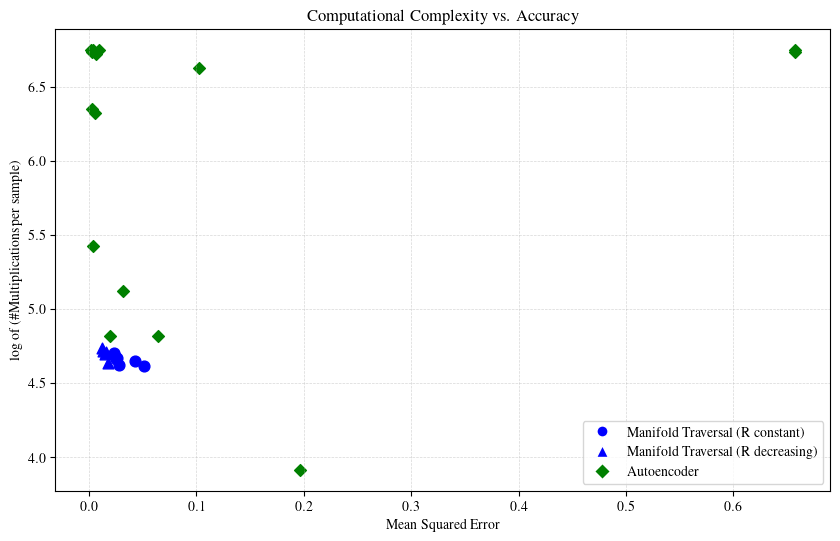

In [12]:
#plot comparison trade-off figure

save_path = f'/data/shiyu/projects/MT/MT_ICML_OOP/GW/GW_results/MT_AE_GW_tradeoff.pdf'


configs = networks_wrapper_GW.get_hyperparameter_configs()
mt_accuracies = [r['mixed_order']['avg_distance'] for r in networks_wrapper_GW.analysis_results]
mt_complexities = [r['mixed_order']['avg_mults'] for r in networks_wrapper_GW.analysis_results]



plt.figure(figsize=(10, 6))

for i in range(len(networks_wrapper_GW.networks)):
    marker_mt = 'o' if configs[i]['R_is_const'] else '^'
    plt.scatter(mt_accuracies[i], np.log10(mt_complexities[i]),
                marker=marker_mt, color='blue', s=60)
    

for i in range(len(AEs_test_MSE_list)):
    plt.scatter(AEs_test_MSE_list[i], np.log10(AEs_mults_per_sample_list[i]), color='green', marker='D')

    
plt.xlabel("Mean Squared Error")
plt.ylabel("log of (\#Multiplications per sample)")
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Manifold Traversal (R constant)', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Manifold Traversal (R decreasing)', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='D', color='w', label='Autoencoder', markerfacecolor='green', markersize=8)
]
plt.legend(handles=legend_elements)
plt.title('Computational Complexity vs. Accuracy')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

if save_path:
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.show()

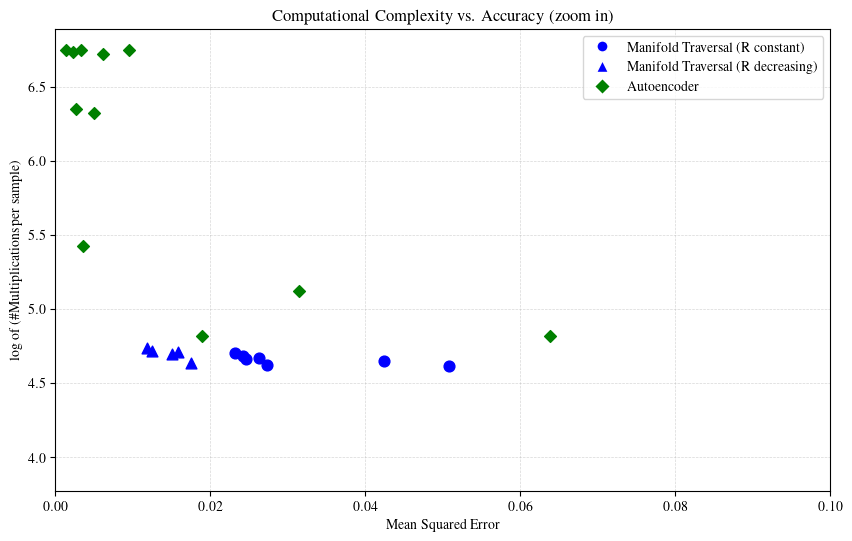

In [13]:
#zoom in
save_path = f'/data/shiyu/projects/MT/MT_ICML_OOP/GW/GW_results/MT_AE_GW_tradeoff_zoomin.pdf'

plt.figure(figsize=(10, 6))

for i in range(len(networks_wrapper_GW.networks)):
    marker_mt = 'o' if configs[i]['R_is_const'] else '^'
    plt.scatter(mt_accuracies[i], np.log10(mt_complexities[i]),
                marker=marker_mt, color='blue', s=60)
    

for i in range(len(AEs_test_MSE_list)):
    plt.scatter(AEs_test_MSE_list[i], np.log10(AEs_mults_per_sample_list[i]), color='green', marker='D')


    
plt.xlabel("Mean Squared Error")
plt.ylabel("log of (\#Multiplications per sample)")
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Manifold Traversal (R constant)', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Manifold Traversal (R decreasing)', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='D', color='w', label='Autoencoder', markerfacecolor='green', markersize=8)
]
plt.legend(handles=legend_elements)
plt.title('Computational Complexity vs. Accuracy (zoom in)')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlim(0, 0.1)

if save_path:
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.show()